In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar

In [23]:
def run_analisis(df, bounds):
    """
    Analyze multi-agent generator-consumer system with dynamic number of agents
    """
    
    def social_welfare(x, a, b, c, epsilon=1e-8):
        """
        x[0] = P: Power
        x[1] = price: Price
        """
        P = x[0]
        price = x[1]

        # Generator cost
        Hg = a * P**2 + b * P + c

        # Generator profit
        gen_profit = P * price - Hg

        # Consumer utility
        con_profit = P * (1 / np.log(1 + price + epsilon))

        # Social welfare: sum of both
        return -(gen_profit + con_profit)  # Negative for maximization

    # Generator utility: optimize x, fix y
    def maximize_generator(x, y_fixed):
        return x * y_fixed - (0.1 * x**2 + 2 * x)

    # Consumer utility: optimize y, fix x
    def maximize_consumer(y, x_fixed):
        if y <= 0:
            return -np.inf  # avoid log error
        return x_fixed / np.log(1 + y)

    # === Detect number of generators and consumers ===
    generator_cols = [col for col in df.columns if col.startswith('generator_') and col.endswith('_power')]
    consumer_cols = [col for col in df.columns if col.startswith('consumer_') and col.endswith('_price')]
    
    n_generators = len(generator_cols)
    n_consumers = len(consumer_cols)
    
    print(f"Detected {n_generators} generators and {n_consumers} consumers")

    # === Calculate Stackelberg equilibrium (using single agent approximation) ===
    x0 = 0.6
    x_fixed = x0

    for i in range(10):
        res_y = minimize_scalar(lambda y: -maximize_consumer(y, x_fixed), bounds=bounds[1], method='bounded')
        best_y = res_y.x

        y_fixed = best_y

        res_x = minimize_scalar(lambda x: -maximize_generator(x, y_fixed), bounds=bounds[0], method='bounded')
        best_x = res_x.x

        x_fixed = best_x

    stk_gen = best_x
    stk_con = best_y

    print(f"Stackelberg equilibrium at point ({stk_gen:.4f}, {stk_con:.4f})")
    
    # === Calculate optimal social welfare ===
    # Coefficients
    a = 0.2
    b = 2
    c = 0

    # Initial guess: P=1, price=1
    x0 = [1, 1]

    res = minimize(social_welfare, x0, args=(a, b, c), bounds=bounds)

    # Results
    opt_P, opt_price = res.x
    max_social_welfare = -res.fun

    print(f"Optimal Power: {opt_P:.4f}")
    print(f"Optimal Price: {opt_price:.4f}")
    print(f"Max Social Welfare: {max_social_welfare:.4f}")

    # === Process multi-agent data ===
    # Create aggregated columns
    df_processed = df.copy()
    
    # Sum all generator powers and profits
    generator_power_cols = [col for col in df.columns if col.startswith('generator_') and col.endswith('_power')]
    generator_profit_cols = [col for col in df.columns if col.startswith('generator_') and col.endswith('_profit')]
    
    df_processed['total_generator_power'] = df_processed[generator_power_cols].sum(axis=1)
    df_processed['total_generator_profit'] = df_processed[generator_profit_cols].sum(axis=1)
    
    # Sum consumer prices and profits
    consumer_price_cols = [col for col in df.columns if col.startswith('consumer_') and col.endswith('_price')]
    consumer_profit_cols = [col for col in df.columns if col.startswith('consumer_') and col.endswith('_profit')]
    
    df_processed['total_consumer_price'] = df_processed[consumer_price_cols].sum(axis=1)
    df_processed['total_consumer_profit'] = df_processed[consumer_profit_cols].sum(axis=1)
    
    # Group by step and calculate means
    grouped = df_processed.groupby('step').agg({
        'total_generator_power': 'mean',
        'total_consumer_price': 'mean',
        'total_generator_profit': 'mean',
        'total_consumer_profit': 'mean'
    }).sort_index()

    # Reference values - keep original Stackelberg values (no scaling)
    ref_power = stk_gen
    ref_price = stk_con
    ref_profit = max_social_welfare

    # === Extract mean vectors ===
    mean_generator_power = grouped['total_generator_power'].values
    mean_consumer_price = grouped['total_consumer_price'].values
    mean_generator_profit = grouped['total_generator_profit'].values
    mean_consumer_profit = grouped['total_consumer_profit'].values
    steps = grouped.index.values

    # === Create subplots ===
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # --- Subplot 1: States ---
    ax1.plot(steps, mean_generator_power, label=f'Total Generator Power ({n_generators} gens)', color='blue', linewidth=2)
    ax1.plot(steps, mean_consumer_price, label=f'Total Consumer Price ({n_consumers} cons)', color='orange', linewidth=2)
    ax1.axhline(ref_power, color='blue', linestyle='--', alpha=0.7, label='Gen. Stack. Eq')
    ax1.axhline(ref_price, color='orange', linestyle='--', alpha=0.7, label='Con. Stack. Eq')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('State Value')
    ax1.set_title('Total Generator Power and Total Consumer Price')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # --- Subplot 2: Total Profits ---
    total_profit = mean_consumer_profit + mean_generator_profit
    ax2.plot(steps, total_profit, label='Total System Profit', color='red', linewidth=2)
    ax2.axhline(ref_profit, color='green', linestyle='--', alpha=0.7, label='Max Welfare Function')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Total Profit')
    ax2.set_title('Total System Profit (All Agents)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # --- Subplot 3: Individual Profits ---
    ax3.plot(steps, mean_generator_profit, label='Total Generator Profit', color='blue', linewidth=2)
    ax3.plot(steps, mean_consumer_profit, label='Total Consumer Profit', color='orange', linewidth=2)
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Profit')
    ax3.set_title('Generator vs Consumer Profits')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # --- Subplot 4: Individual Agent Performance ---
    if n_generators > 1 or n_consumers > 1:
        # Show individual agent performance for first few agents
        for i in range(min(3, n_generators)):
            power_col = f'generator_{i}_power'
            if power_col in df.columns:
                agent_data = df.groupby('step')[power_col].mean()
                ax4.plot(agent_data.index, agent_data.values, 
                        label=f'Gen {i} Power', alpha=0.7, linestyle='-')
        
        for i in range(min(3, n_consumers)):
            price_col = f'consumer_{i}_price'
            if price_col in df.columns:
                agent_data = df.groupby('step')[price_col].mean()
                ax4.plot(agent_data.index, agent_data.values, 
                        label=f'Con {i} Price', alpha=0.7, linestyle='--')
        
        ax4.set_xlabel('Step')
        ax4.set_ylabel('Individual Agent States')
        ax4.set_title('Individual Agent Performance (First 3 of each type)')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Single agent system\n(see other plots)', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Individual Agent Analysis')

    plt.tight_layout()
    plt.show()

    # === Print summary statistics ===
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Final total generator power: {mean_generator_power[-1]:.4f}")
    print(f"Final total consumer price: {mean_consumer_price[-1]:.4f}")
    print(f"Final total system profit: {total_profit[-1]:.4f}")
    print(f"Convergence to Stackelberg (power): {abs(mean_generator_power[-1] - ref_power)/ref_power*100:.2f}% difference")
    print(f"Convergence to Stackelberg (price): {abs(mean_consumer_price[-1] - ref_price)/ref_price*100:.2f}% difference")
    
    return {
        'n_generators': n_generators,
        'n_consumers': n_consumers,
        'stackelberg_power': ref_power,
        'stackelberg_price': ref_price,
        'max_welfare': ref_profit
    }

# Example usage:
# df = pd.read_csv('your_data.csv')
# bounds = [(0.1, 2), (0.1, 2)]  # [(power_bounds), (price_bounds)]
# results = run_analisis(df, bounds)

# 1 Generator - 1 Consumer

Detected 1 generators and 1 consumers
Stackelberg equilibrium at point (0.1000, 0.1000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


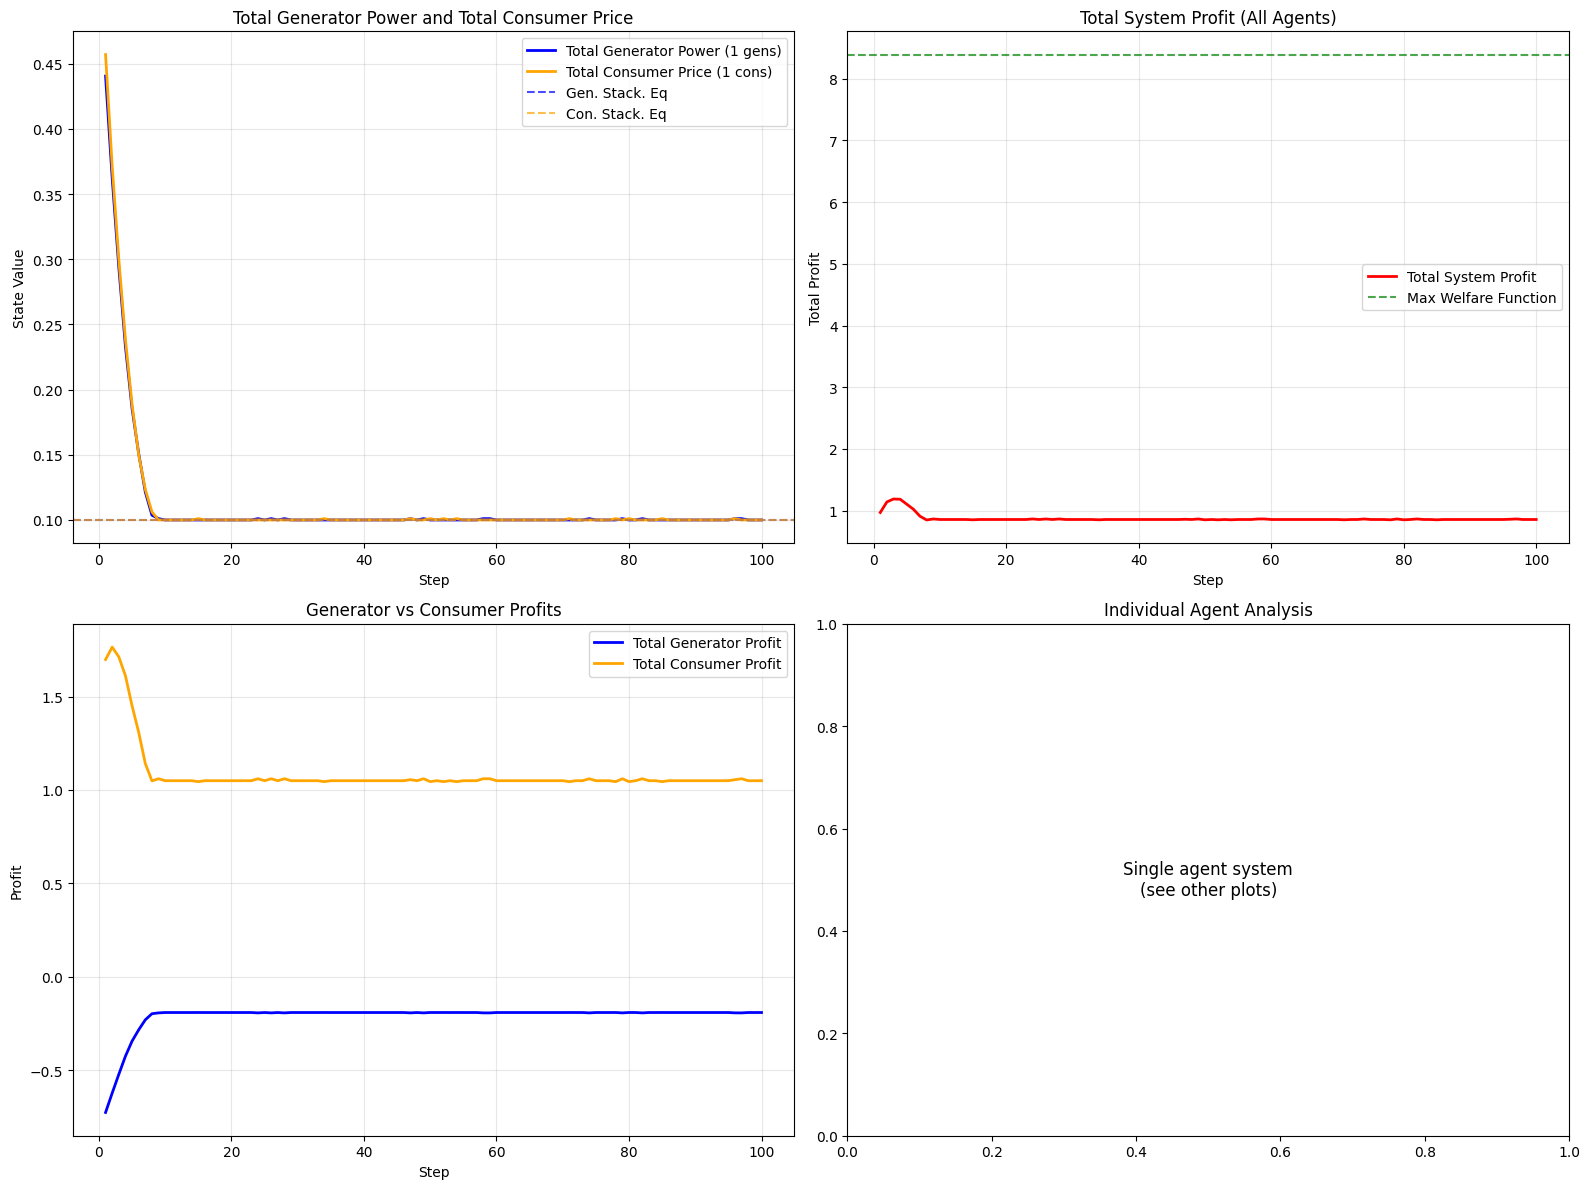


SUMMARY STATISTICS
Final total generator power: 0.1000
Final total consumer price: 0.1000
Final total system profit: 0.8572
Convergence to Stackelberg (power): 0.01% difference
Convergence to Stackelberg (price): 0.01% difference


{'n_generators': 1,
 'n_consumers': 1,
 'stackelberg_power': 0.10000534557140882,
 'stackelberg_price': 0.10000534557140882,
 'max_welfare': 8.392057686499935}

In [26]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_p2p/p2p_market_case1_2025-06-20_16-37-01/market_log_all_episodes_2025-06-20_21-36-46.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(0.1,1), (0.1,1)] )

Detected 1 generators and 1 consumers
Stackelberg equilibrium at point (-1.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


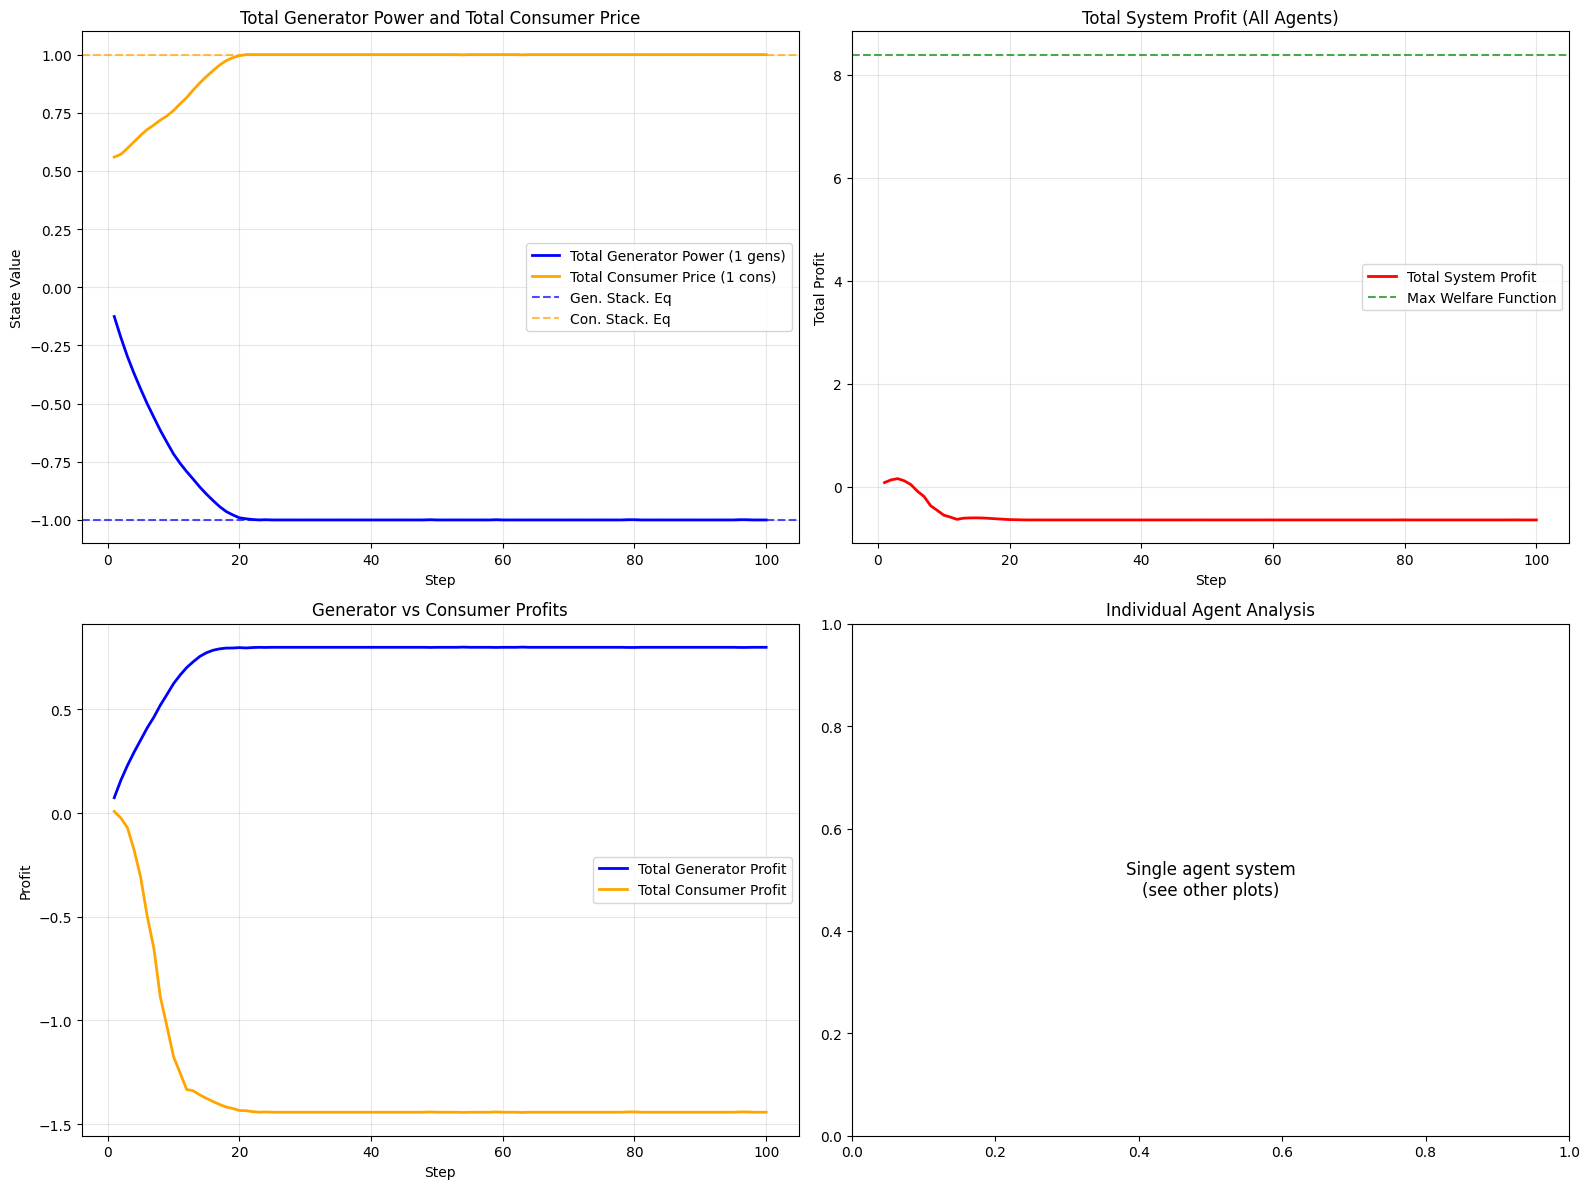


SUMMARY STATISTICS
Final total generator power: -1.0000
Final total consumer price: 1.0000
Final total system profit: -0.6427
Convergence to Stackelberg (power): -0.00% difference
Convergence to Stackelberg (price): 0.00% difference


{'n_generators': 1,
 'n_consumers': 1,
 'stackelberg_power': -0.9999959801362373,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [24]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_p2p/p2p_market_case2_2025-06-20_13-15-44/market_log_all_episodes_2025-06-20_18-15-29.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-1,1), (0.1,1)] )

Detected 1 generators and 1 consumers
Stackelberg equilibrium at point (-5.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


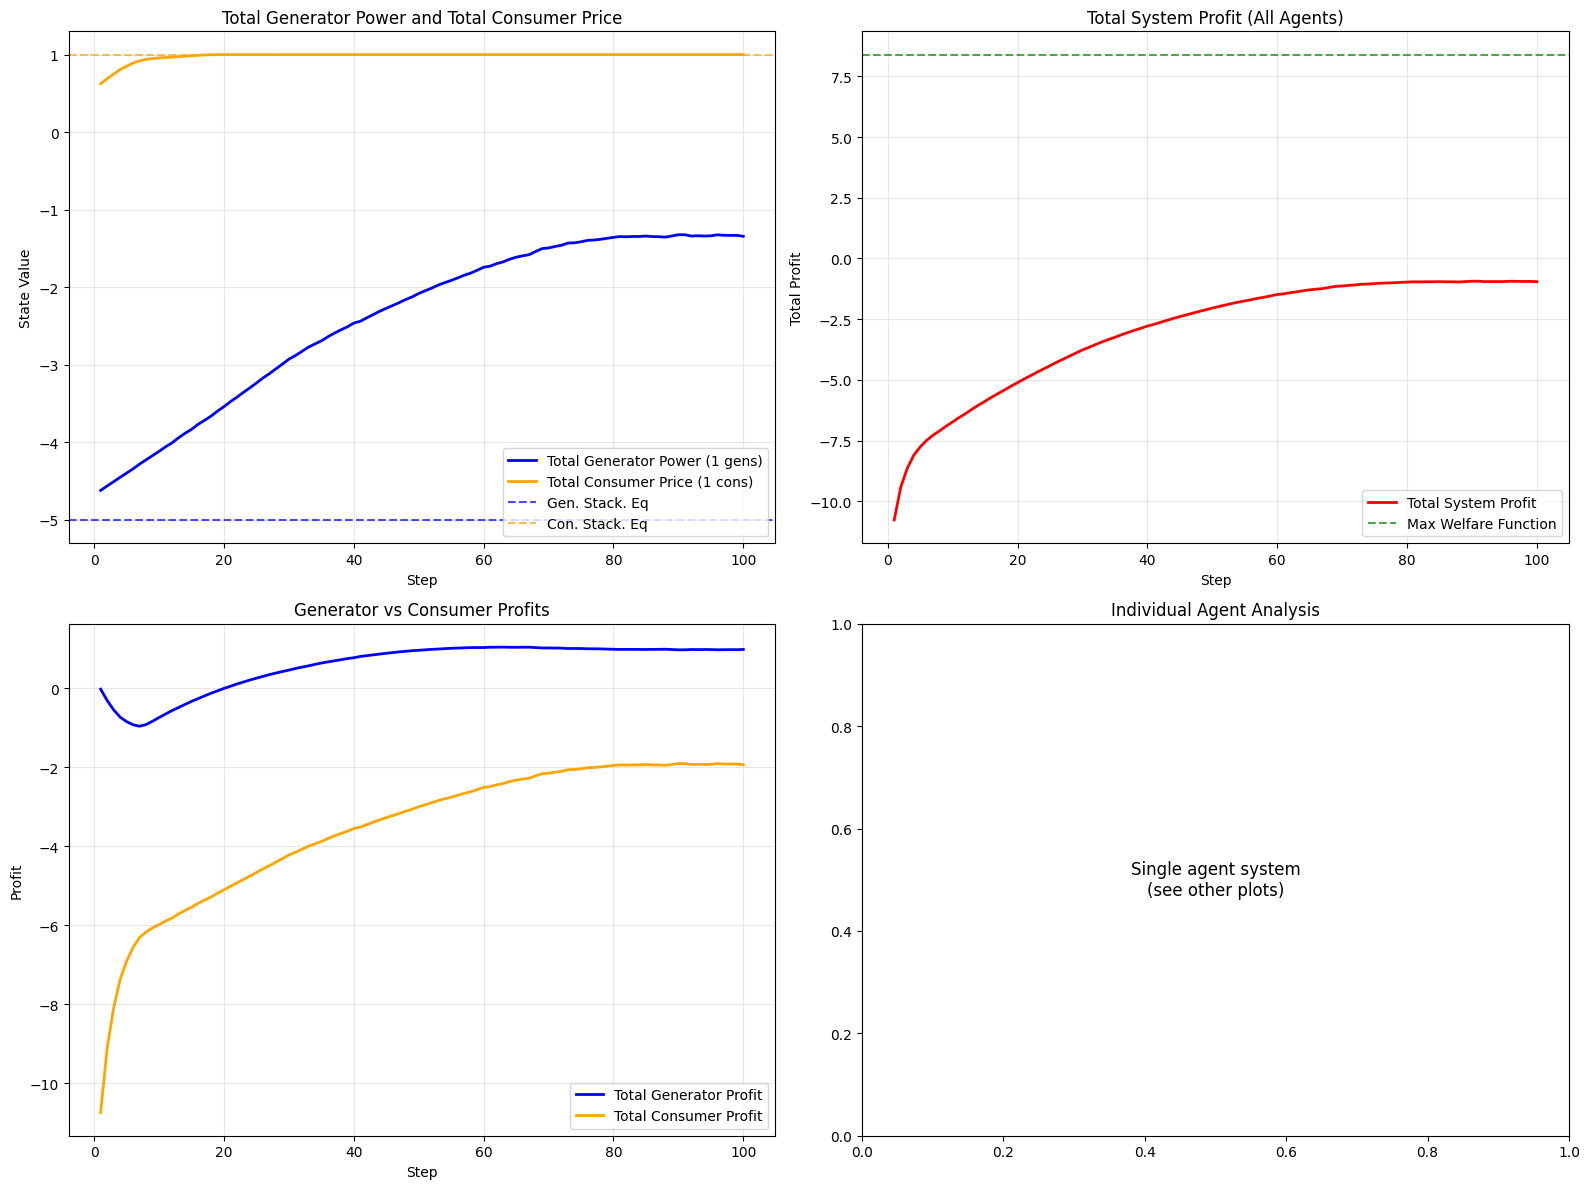


SUMMARY STATISTICS
Final total generator power: -1.3425
Final total consumer price: 1.0000
Final total system profit: -0.9563
Convergence to Stackelberg (power): -73.15% difference
Convergence to Stackelberg (price): 0.00% difference


{'n_generators': 1,
 'n_consumers': 1,
 'stackelberg_power': -5.000027601167147,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [27]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_p2p/p2p_market_case3_2025-06-20_17-32-38/market_log_all_episodes_2025-06-20_22-32-23.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-10,1), (0.1,1)] )

Detected 1 generators and 1 consumers
Stackelberg equilibrium at point (-2.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


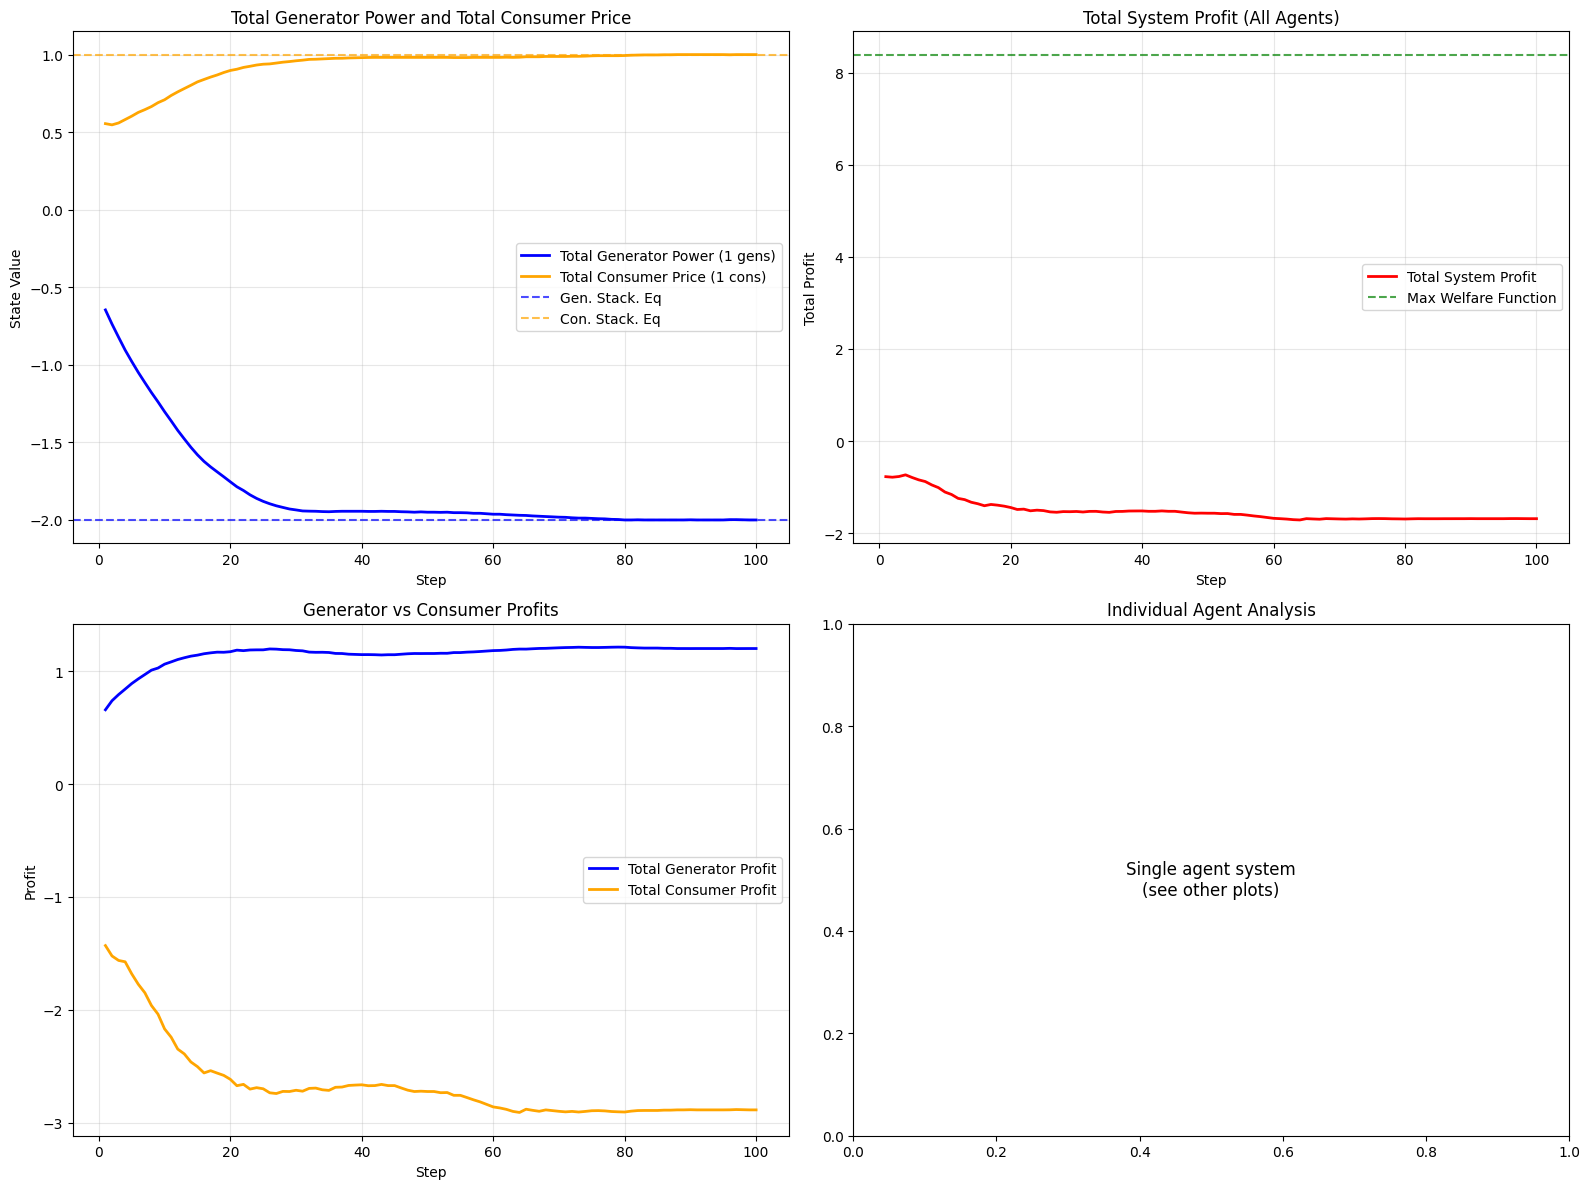


SUMMARY STATISTICS
Final total generator power: -2.0000
Final total consumer price: 1.0000
Final total system profit: -1.6854
Convergence to Stackelberg (power): -0.00% difference
Convergence to Stackelberg (price): 0.00% difference


{'n_generators': 1,
 'n_consumers': 1,
 'stackelberg_power': -1.9999965324591422,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [28]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_p2p/p2p_market_case4_2025-06-24_16-15-37/market_log_all_episodes_2025-06-24_21-15-22.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-2,1), (0.1,1)] )

# 2 Generators - 2 Consumers

Detected 2 generators and 2 consumers
Stackelberg equilibrium at point (0.1000, 0.1000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


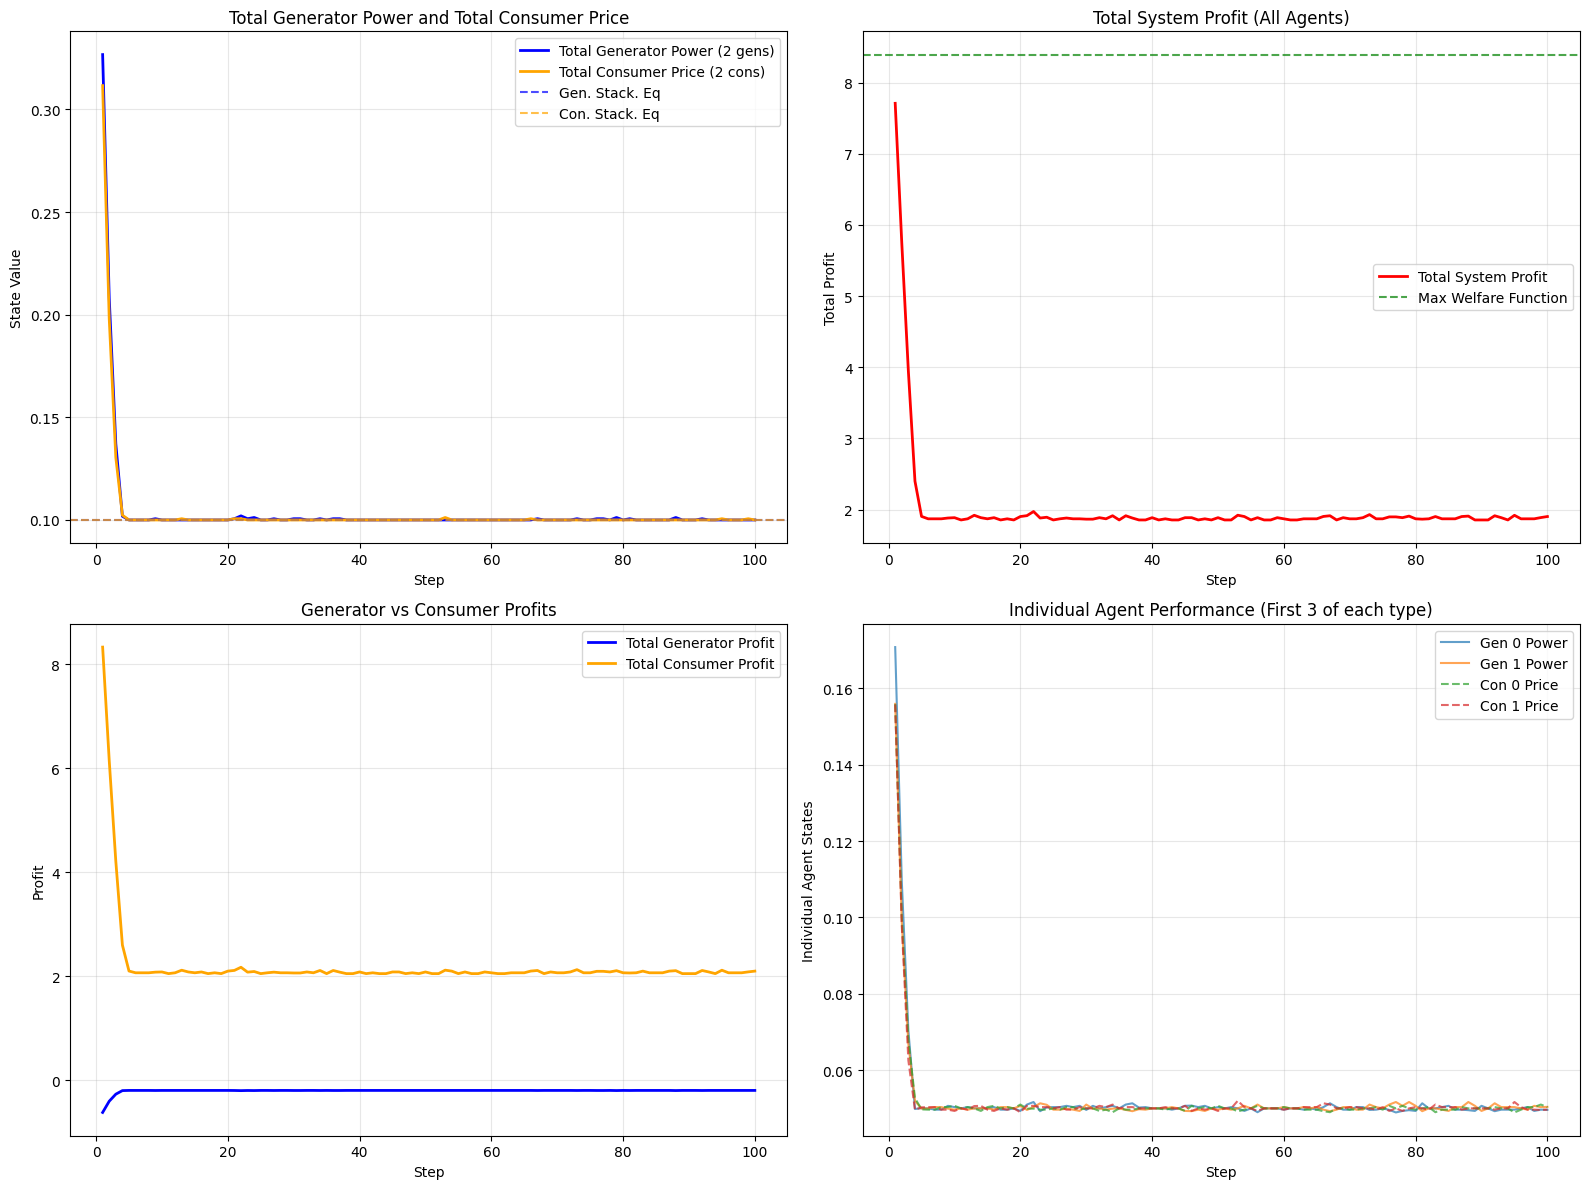


SUMMARY STATISTICS
Final total generator power: 0.1000
Final total consumer price: 0.1000
Final total system profit: 1.9016
Convergence to Stackelberg (power): 0.01% difference
Convergence to Stackelberg (price): 0.01% difference


{'n_generators': 2,
 'n_consumers': 2,
 'stackelberg_power': 0.10000534557140882,
 'stackelberg_price': 0.10000534557140882,
 'max_welfare': 8.392057686499935}

In [30]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case1_2025-06-25_16-48-43/market_log_all_episodes_2025-06-25_21-48-24.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(0.1,1), (0.1,1)] )

Detected 2 generators and 2 consumers
Stackelberg equilibrium at point (-1.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


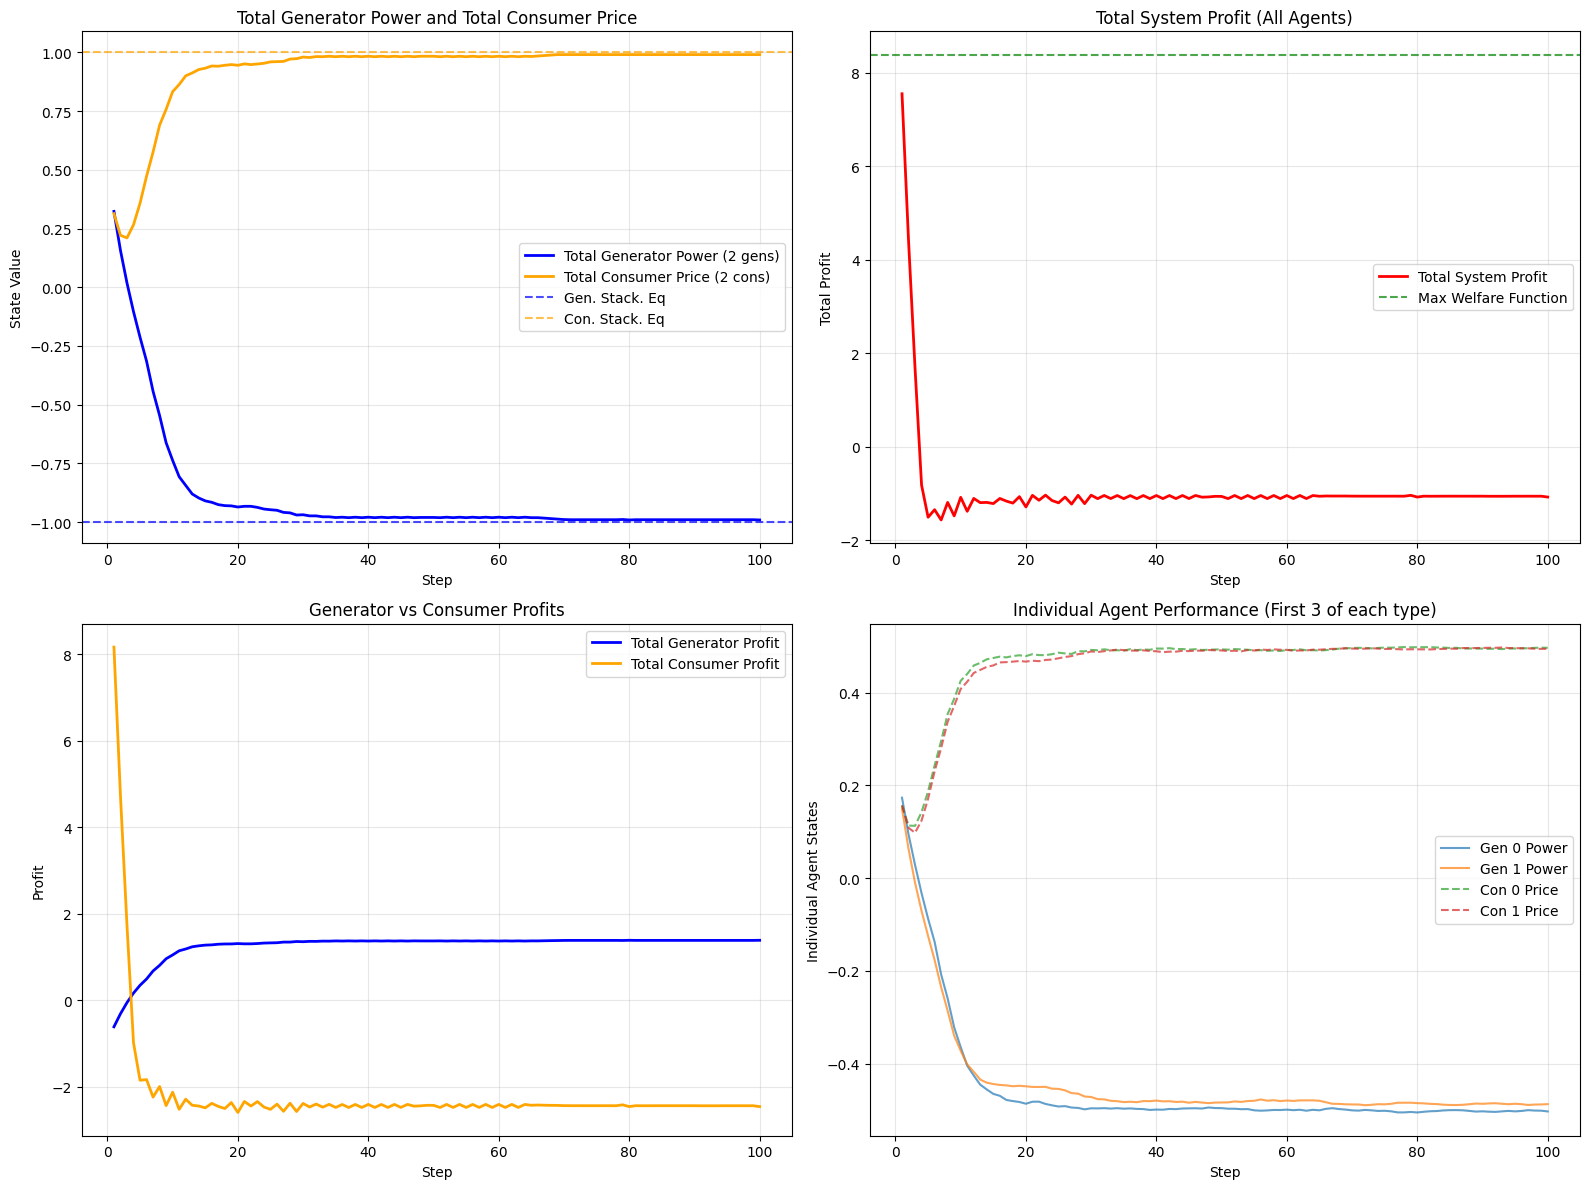


SUMMARY STATISTICS
Final total generator power: -0.9910
Final total consumer price: 0.9910
Final total system profit: -1.0782
Convergence to Stackelberg (power): -0.90% difference
Convergence to Stackelberg (price): 0.90% difference


{'n_generators': 2,
 'n_consumers': 2,
 'stackelberg_power': -0.9999959801362373,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [33]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case2_2025-06-25_18-33-02/market_log_all_episodes_2025-06-25_23-32-43.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-1,1), (0.1,1)] )

# 2 Generators - 1 Consumers

Detected 2 generators and 1 consumers
Stackelberg equilibrium at point (0.1000, 0.1000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


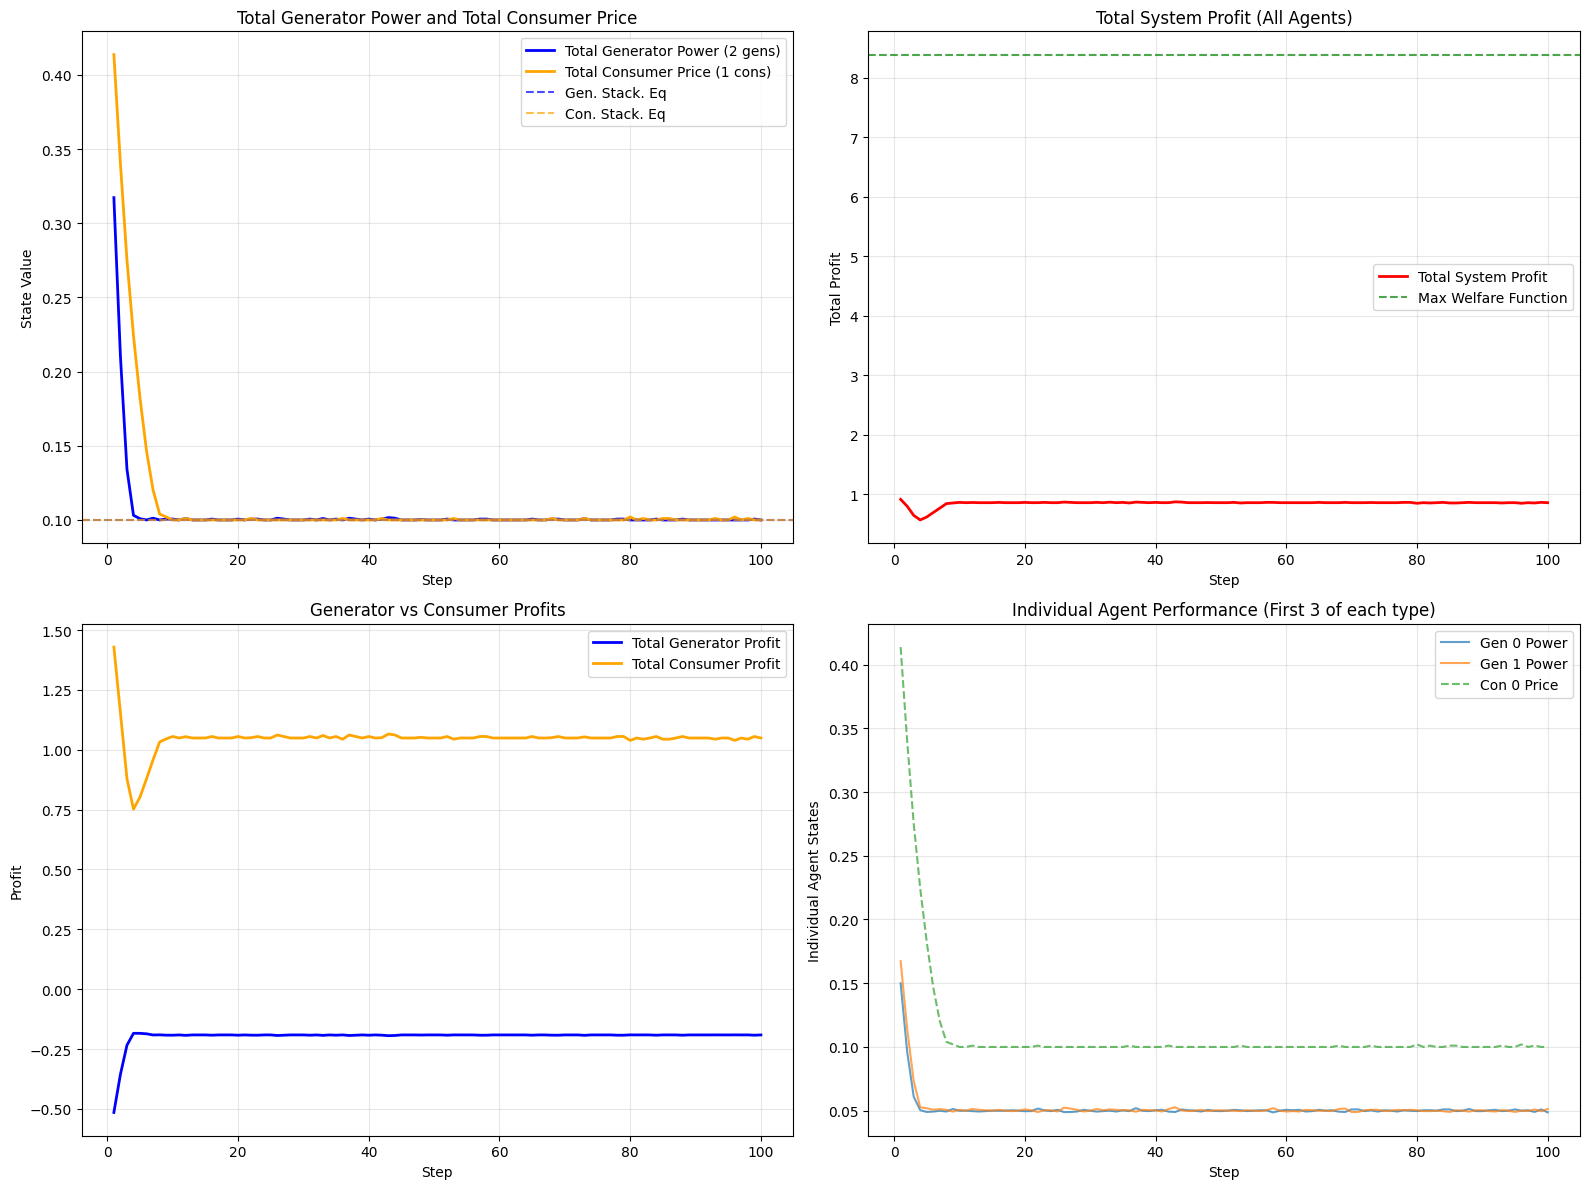


SUMMARY STATISTICS
Final total generator power: 0.1000
Final total consumer price: 0.1000
Final total system profit: 0.8582
Convergence to Stackelberg (power): 0.01% difference
Convergence to Stackelberg (price): 0.01% difference


{'n_generators': 2,
 'n_consumers': 1,
 'stackelberg_power': 0.10000534557140882,
 'stackelberg_price': 0.10000534557140882,
 'max_welfare': 8.392057686499935}

In [37]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case3_2025-06-25_19-03-35/market_log_all_episodes_2025-06-26_00-03-18.csv'  # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(0.1,1), (0.1,1)] )

Detected 2 generators and 1 consumers
Stackelberg equilibrium at point (-1.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


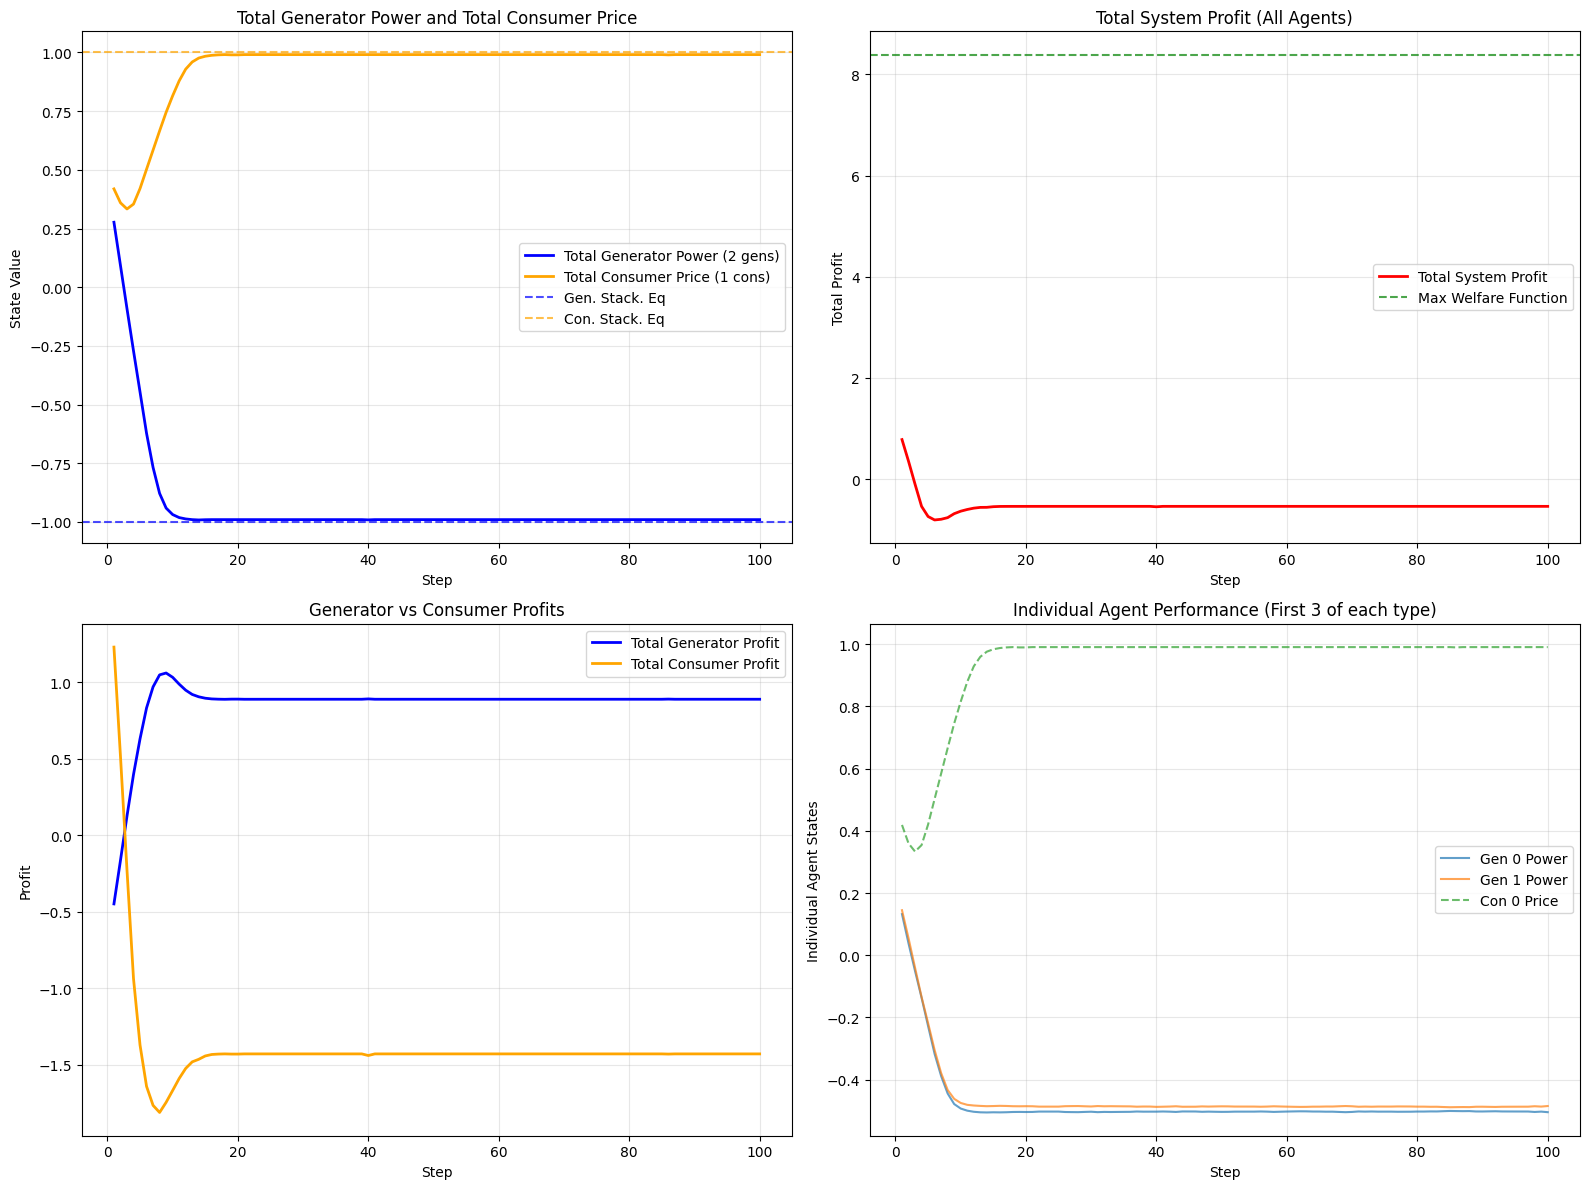


SUMMARY STATISTICS
Final total generator power: -0.9900
Final total consumer price: 0.9910
Final total system profit: -0.5399
Convergence to Stackelberg (power): -1.00% difference
Convergence to Stackelberg (price): 0.90% difference


{'n_generators': 2,
 'n_consumers': 1,
 'stackelberg_power': -0.9999959801362373,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [40]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case3_2025-06-25_19-14-47/market_log_all_episodes_2025-06-26_00-14-29.csv'   # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-1,1), (0.1,1)] )

# 3 Generators - 3 Consumers

Detected 3 generators and 3 consumers
Stackelberg equilibrium at point (0.1000, 0.1000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


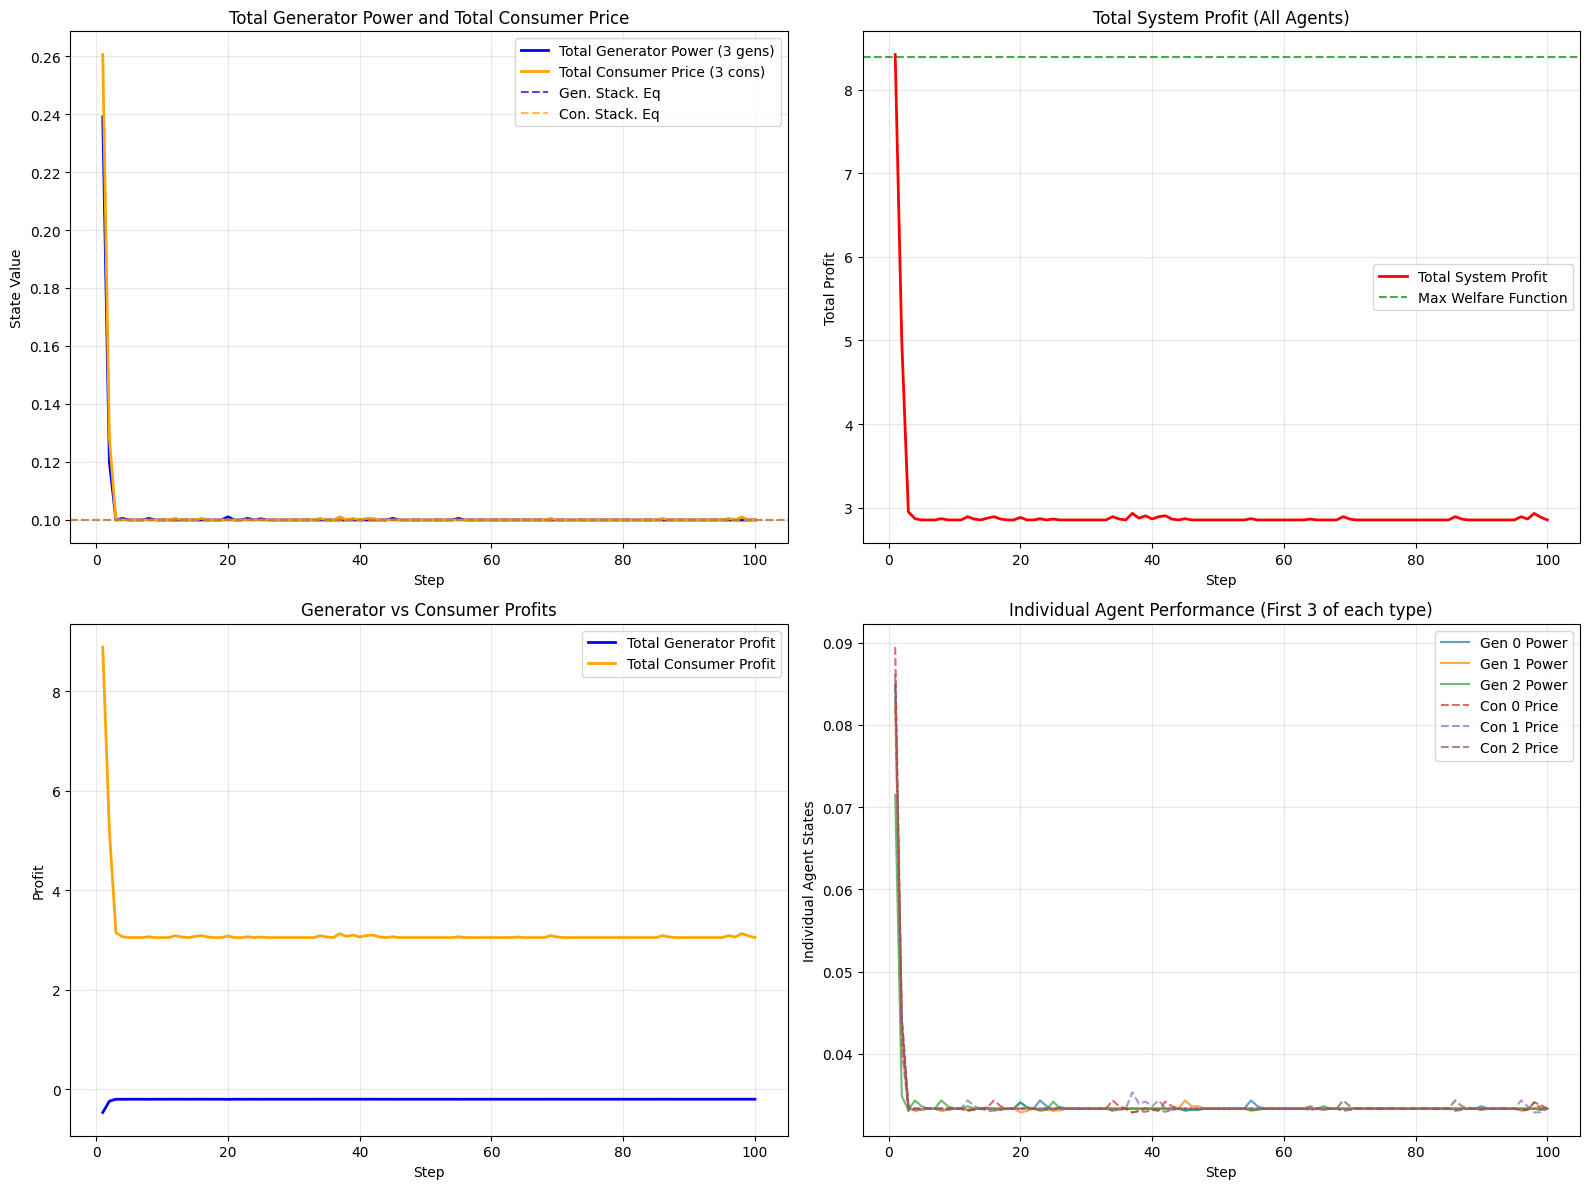


SUMMARY STATISTICS
Final total generator power: 0.1000
Final total consumer price: 0.1000
Final total system profit: 2.8524
Convergence to Stackelberg (power): 0.01% difference
Convergence to Stackelberg (price): 0.01% difference


{'n_generators': 3,
 'n_consumers': 3,
 'stackelberg_power': 0.10000534557140882,
 'stackelberg_price': 0.10000534557140882,
 'max_welfare': 8.392057686499935}

In [41]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case3_2025-06-25_19-26-35/market_log_all_episodes_2025-06-26_00-26-12.csv'   # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(0.1,1), (0.1,1)] )

Detected 3 generators and 3 consumers
Stackelberg equilibrium at point (-1.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


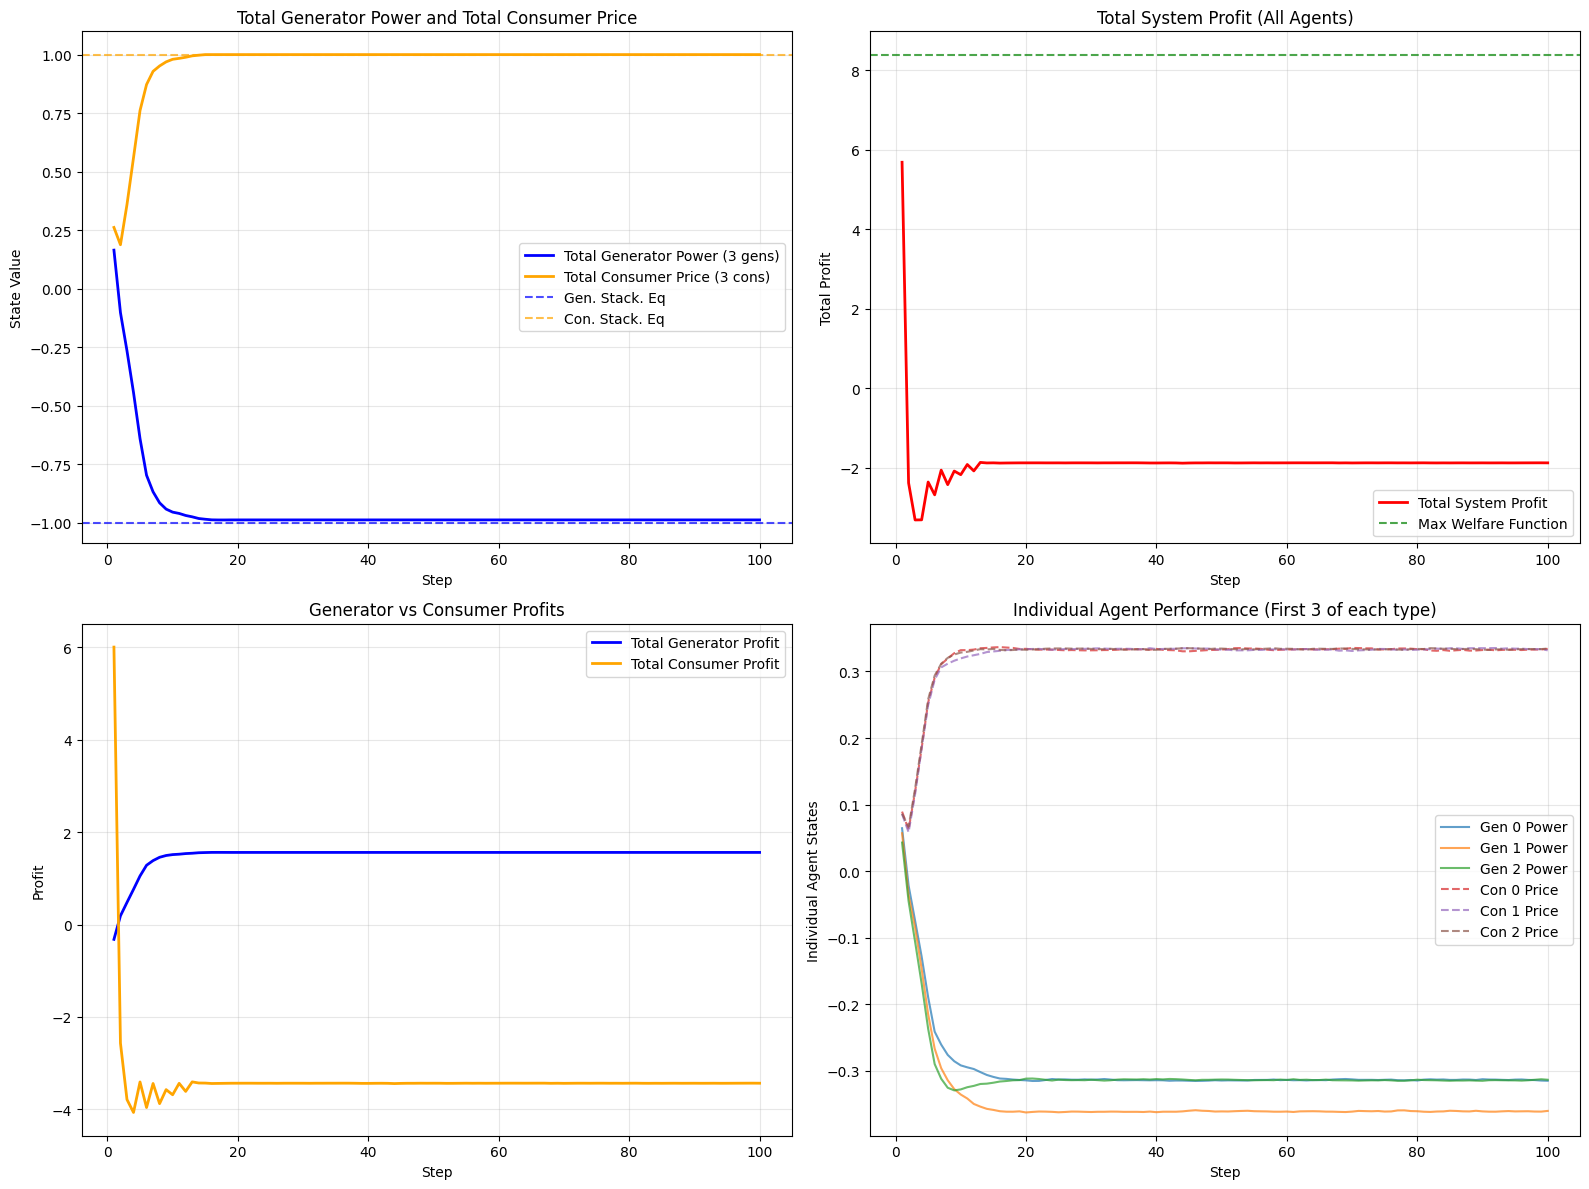


SUMMARY STATISTICS
Final total generator power: -0.9880
Final total consumer price: 1.0000
Final total system profit: -1.8750
Convergence to Stackelberg (power): -1.20% difference
Convergence to Stackelberg (price): 0.00% difference


{'n_generators': 3,
 'n_consumers': 3,
 'stackelberg_power': -0.9999959801362373,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [42]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case3_2025-06-25_19-32-36/market_log_all_episodes_2025-06-26_00-32-14.csv'   # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-1,1), (0.1,1)] )

# 3 Generators - 1 Prosumer

Detected 3 generators and 1 consumers
Stackelberg equilibrium at point (0.1000, 0.1000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


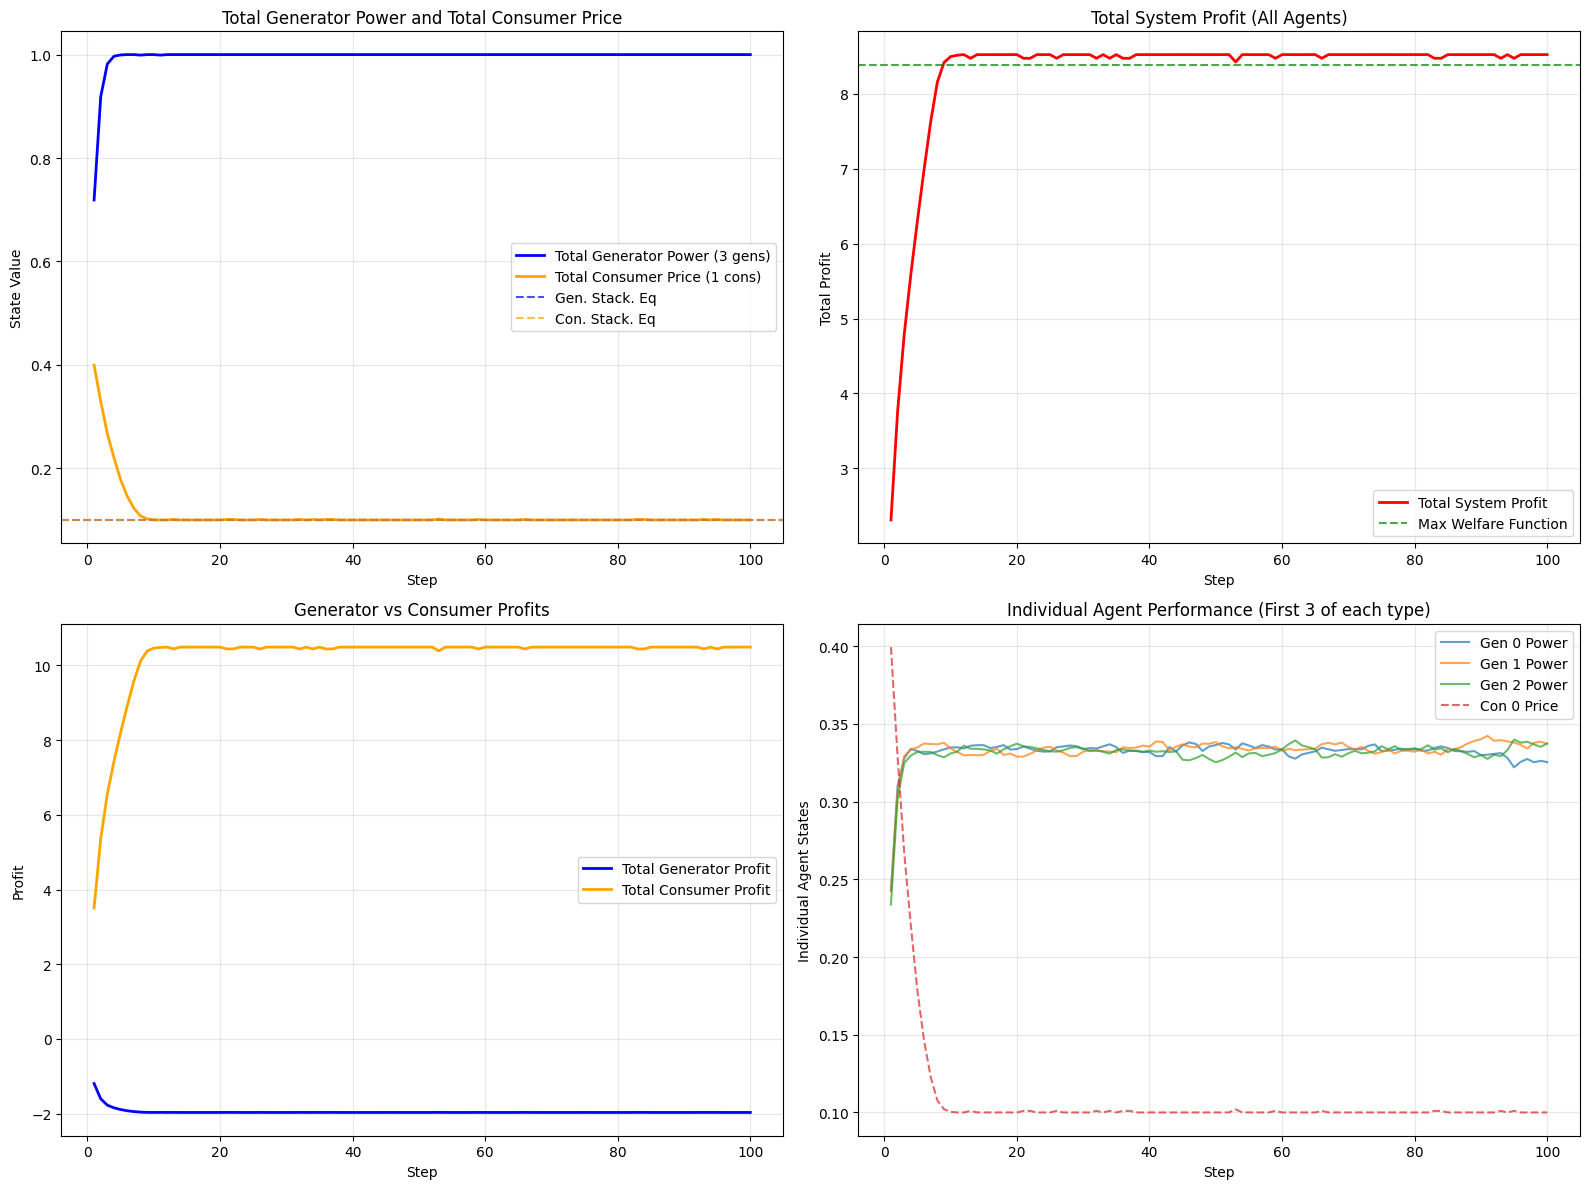


SUMMARY STATISTICS
Final total generator power: 1.0000
Final total consumer price: 0.1000
Final total system profit: 8.5248
Convergence to Stackelberg (power): 899.95% difference
Convergence to Stackelberg (price): 0.01% difference


{'n_generators': 3,
 'n_consumers': 1,
 'stackelberg_power': 0.10000534557140882,
 'stackelberg_price': 0.10000534557140882,
 'max_welfare': 8.392057686499935}

In [43]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case3_2025-06-25_19-39-42/market_log_all_episodes_2025-06-26_00-39-23.csv'   # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(0.1,1), (0.1,1)] )

Detected 3 generators and 1 consumers
Stackelberg equilibrium at point (-1.0000, 1.0000)
Optimal Power: 1.0000
Optimal Price: 0.1000
Max Social Welfare: 8.3921


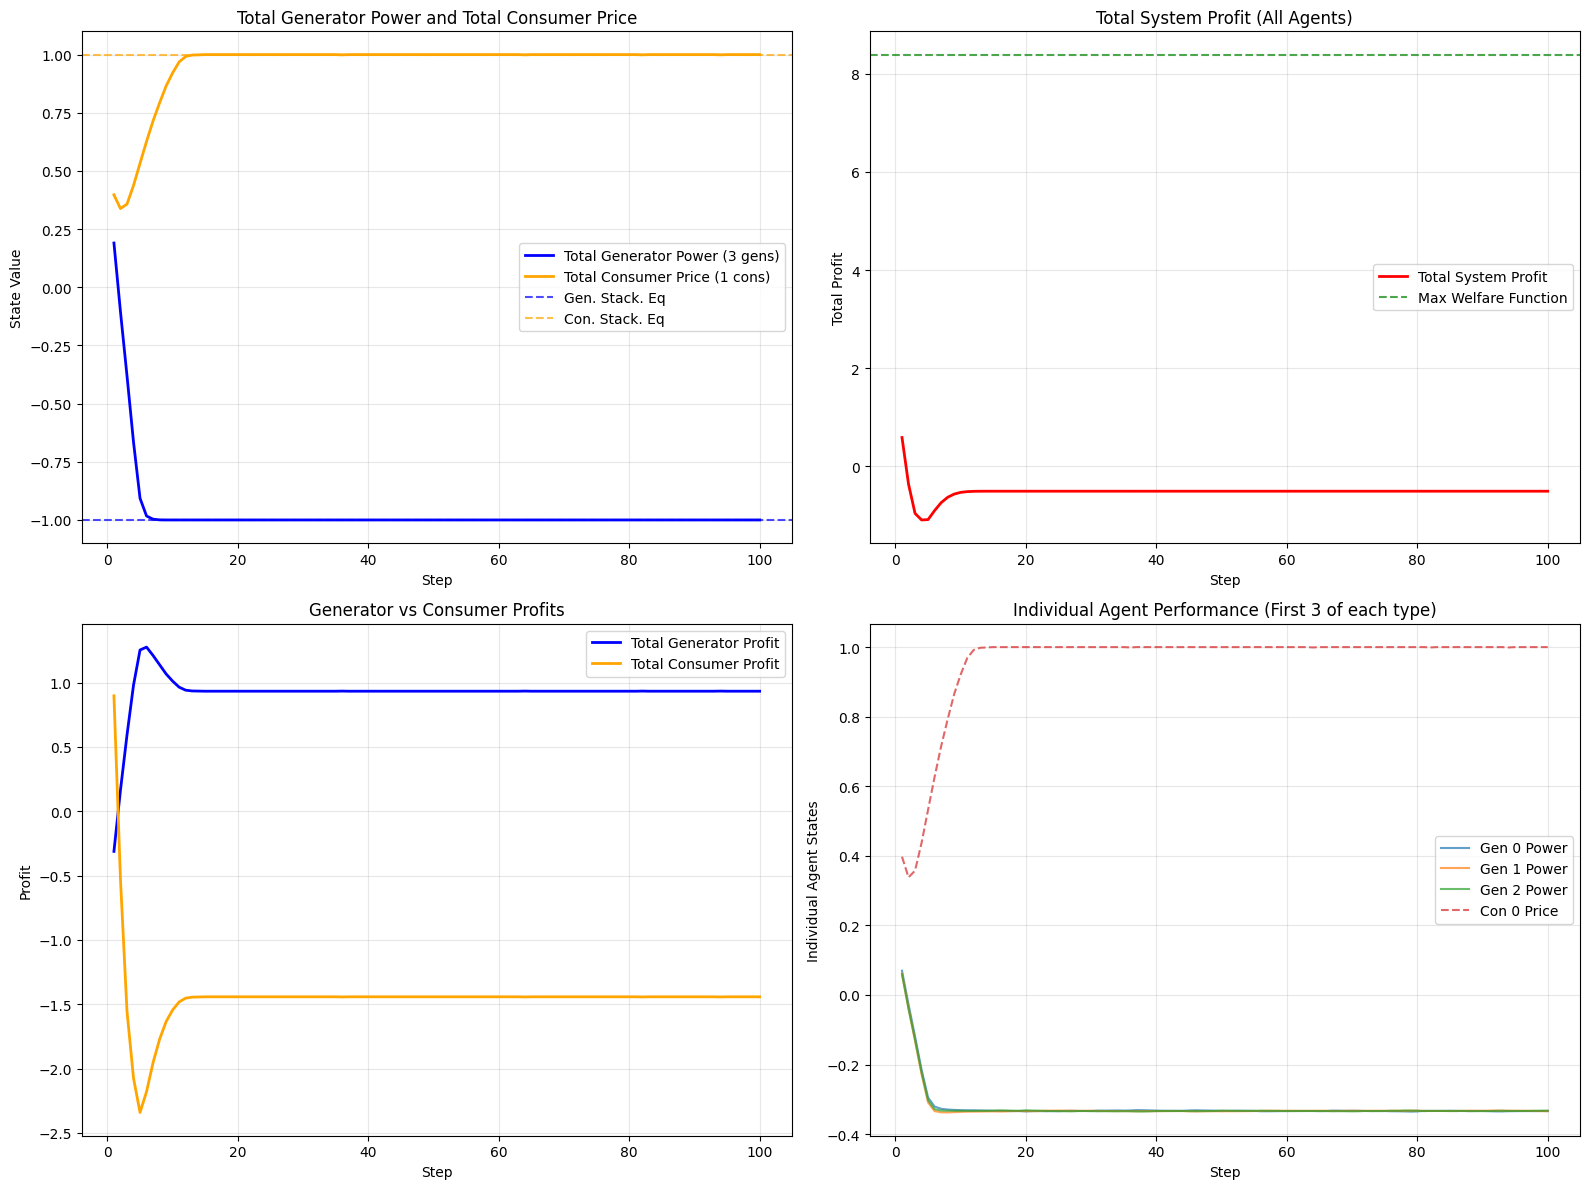


SUMMARY STATISTICS
Final total generator power: -1.0000
Final total consumer price: 1.0000
Final total system profit: -0.5094
Convergence to Stackelberg (power): -0.00% difference
Convergence to Stackelberg (price): 0.00% difference


{'n_generators': 3,
 'n_consumers': 1,
 'stackelberg_power': -0.9999959801362373,
 'stackelberg_price': 0.9999944797665706,
 'max_welfare': 8.392057686499935}

In [44]:
# === Load the CSV log ===
csv_file = 'evaluated_policies/maa2c_mlp_energy_market/energy_market_case3_2025-06-25_19-45-09/market_log_all_episodes_2025-06-26_00-44-50.csv'   # <-- update your actual file name
df_case2 = pd.read_csv(csv_file)

run_analisis(df_case2, [(-1,1), (0.1,1)] )